# Employee Attrition prediction using KNN, RF, DT and SVM with up-sampling to the data

In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (accuracy_score,
                             f1_score,
                             roc_auc_score,
                             roc_curve,
                             confusion_matrix)
from sklearn.model_selection import (cross_val_score,
                                     GridSearchCV,
                                     RandomizedSearchCV,
                                     learning_curve,
                                     validation_curve,
                                     train_test_split)
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from warnings import filterwarnings


%matplotlib inline

In [2]:
import sys
import pandas as pd # data processing, CSV file I/O
import numpy as np # linear algebra
import sklearn
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns

# Load the data
df = pd.read_csv('Downloads/HR_comma_sep.csv')
# Check both the datatypes and if there is missing values
print('\033[1m' + '\033[94m' + 'Data types:\n' + 11 * '-')
print('\033[30m' + '{}\n'.format(df.dtypes))
print('\033[1m' + '\033[94m' + 'Sum of null values in each column:\n' + 35 * '-')
print('\033[30m' + '{}'.format(df.isnull().sum()))
df.head()

Data types:
-----------
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Sum of null values in each column:
-----------------------------------
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


* There are no missing values, no imputation required. However, data preprocessing is needed:
* Changing sales feature name to department.
* Convert salary into ordinal categorical feature since there is intrinsic order between: low, medium and high.
* Create dummy features from department feature and drop the first one to avoid linear dependency where some learning algorithms may struggle.


In [3]:
# Rename sales feature into department
df = df.rename(columns={"sales": "department"})
# Map salary into integers
salary_map = {"low": 0, "medium": 1, "high": 2}
df["salary"] = df["salary"].map(salary_map)
# Create dummy variables for department feature
df = pd.get_dummies(df, columns=["department"], drop_first=True)

# Modeling
Let’s look at the ratio of each class to see if there are balanced or imbalanced data, since each one has its own set of tools to be used when fitting classifiers.

Positive examples = 3571
Negative examples = 11428
Proportion of positive to negative examples = 31.25%


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


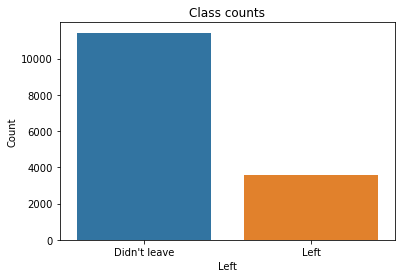

In [4]:
# Get number of positve and negative examples
pos = df[df["left"] == 1].shape[0]
neg = df[df["left"] == 0].shape[0]
print("Positive examples = {}".format(pos))
print("Negative examples = {}".format(neg))
print("Proportion of positive to negative examples = {:.2f}%".format((pos / neg) * 100))
sns.countplot(df["left"])
plt.xticks((0, 1), ["Didn't leave", "Left"])
plt.xlabel("Left")
plt.ylabel("Count")
plt.title("Class counts");

The above graph shows, we have an imbalanced dataset. As a result, when we fit classifiers on such datasets, we should use metrics other than accuracy when comparing models such as f1-score or AUC (area under ROC curve). Moreover, class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. There are three ways to deal with this issue:
* 1- Assign a larger penalty to wrong predictions from the minority class.
* 2- Upsampling the minority class or downsampling the majority class.
* 3- Generate synthetic training examples.

In [5]:
! pip install resample

In [7]:
from sklearn.model_selection import train_test_split
from pandas.tseries.frequencies import to_offset
from sklearn.utils import resample

# Convert dataframe into numpy objects and split them into
# train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.flatten()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1)
# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))
# Downsample majority class
X_train_d, y_train_d = resample(X_train[y_train == 0],
                                y_train[y_train == 0],
                                replace=True,
                                n_samples=X_train[y_train == 1].shape[0],
                                random_state=1)
X_train_d = np.concatenate((X_train[y_train == 1], X_train_d))
y_train_d = np.concatenate((y_train[y_train == 1], y_train_d))
print("Original shape:", X_train.shape, y_train.shape)
print("Upsampled shape:", X_train_u.shape, y_train_u.shape)
print("Downsampled shape:", X_train_d.shape, y_train_d.shape)

Original shape: (11999, 17) (11999,)
Upsampled shape: (18284, 17) (18284,)
Downsampled shape: (5714, 17) (5714,)


# Lets see how many principal components needed to explain 90%, 95% and 99% of the variation in the data.

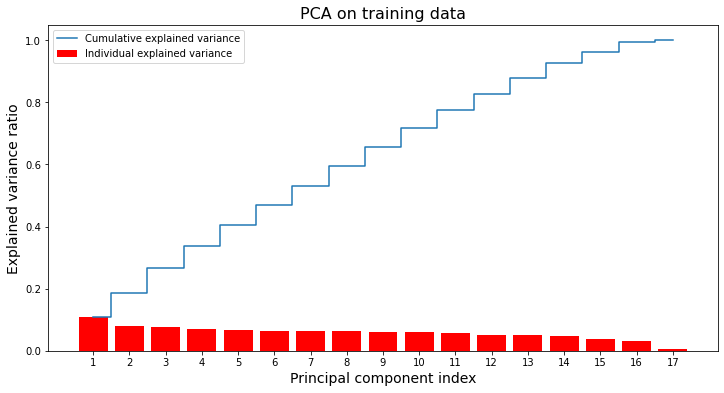

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Build PCA using standarized trained data
pca = PCA(n_components=None, svd_solver="full")
pca.fit(StandardScaler().fit_transform(X_train))
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), pca.explained_variance_ratio_, align="center",
        color='red', label="Individual explained variance")
plt.step(range(1, 18), cum_var_exp, where="mid", label="Cumulative explained variance")
plt.xticks(range(1, 18))
plt.legend(loc="best")
plt.xlabel("Principal component index", {"fontsize": 14})
plt.ylabel("Explained variance ratio", {"fontsize": 14})
plt.title("PCA on training data", {"fontsize": 16});

# Random Forest

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Binarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV

In [37]:
from sklearn.pipeline import Pipeline
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u),
                "Downsampled": (X_train_d, y_train_d)}
for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(),
                           RandomForestClassifier(n_estimators=500,
                                                  class_weight="balanced",
                                                  random_state=123))
    
    hyperparam_grid = {
        "randomforestclassifier__n_estimators": [10, 50, 100, 500],
        "randomforestclassifier__max_features": ["sqrt", "log2", 0.4, 0.5],
        "randomforestclassifier__min_samples_leaf": [1, 3, 5],
        "randomforestclassifier__criterion": ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring="f1",
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])
    
    print(f"\033[1m\033[0mThe best hyperparameters for {method} data:")
    for hyperparam in gs_rf.best_params_.keys():
        print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_rf.best_params_[hyperparam])
        
    print(f"\033[1m\033[94mBest 10-folds CV f1-score: {gs_rf.best_score_ * 100:.2f}%.")
    

The best hyperparameters for Original data:
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 98.23%.
The best hyperparameters for Upsampled data:
criterion :  entropy
max_features :  0.4
min_samples_leaf :  1
n_estimators :  500
Best 10-folds CV f1-score: 99.80%.
The best hyperparameters for Downsampled data:
criterion :  gini
max_features :  0.5
min_samples_leaf :  1
n_estimators :  50
Best 10-folds CV f1-score: 98.46%.


In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

In [12]:
gs_rf.fit(X_train, y_train)
print ("\n\n ---Random Forest Model---")
gs_rf_roc_auc = roc_auc_score(y_test, gs_rf.predict(X_test))
print ("Random Forest AUC = %2.2f" % gs_rf_roc_auc)
print(classification_report(y_test, gs_rf.predict(X_test)))



 ---Random Forest Model---
Random Forest AUC = 0.99
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       1.00      0.97      0.98       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000



Upsampling yielded the highest CV f1-score with 99.8%. Therefore, we’ll be using the upsampled data to fit the rest of the classifiers. The new data now has 18,284 examples: 50% belonging to the positive class, and 50% belonging to the negative class.
Let’s refit the Random Forest with Upsampled data using best hyperparameters tuned above and plot confusion matrix and ROC curve using test data.

# K-Nearest Neighbors
KNN is called a lazy learning algorithm because it doesn’t learn or fit any parameter. It takes n_neighbors points from the training data closest to the point we're interested to predict it's class and take the mode (majority vote) of the classes for the neighboring point as its class. The two hyperparameters we're going to tune are:

* n_neighbors: number of neighbors to use in prediction.
* weights: how much weight to assign neighbors based on:
    * “uniform”: all neighboring points have the same weight.
    * “distance”: use the inverse of euclidean distance of each neighboring point used in prediction.
Let’s fit KNN classifier and plot confusion matrix and ROC curve.

In [13]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)
gs_knn = GridSearchCV(pip_knn,
                      param_grid={"kneighborsclassifier__n_neighbors": hyperparam_range,
                                  "kneighborsclassifier__weights": ["uniform", "distance"]},
                      scoring="f1",
                      cv=10,
                      n_jobs=-1)
gs_knn.fit(X_train, y_train)
print(f"\033[1m\033[0mThe best hyperparameters:\n{'-' * 25}")
for hyperparam in gs_knn.best_params_.keys():
    print(hyperparam[hyperparam.find("__") + 2:], ": ", gs_knn.best_params_[hyperparam])
print("\033[1m" + "\033[94m" + "Best 10-folds CV f1-score: {:.2f}%.".format((gs_knn.best_score_) * 100))


The best hyperparameters:
-------------------------
n_neighbors :  1
weights :  uniform
Best 10-folds CV f1-score: 92.87%.


In [14]:
gs_knn.fit(X_train, y_train)
print ("\n\n ---KNN Model---")
gs_knn_roc_auc = roc_auc_score(y_test, gs_knn.predict(X_test))
print ("kneighbors classifier AUC = %2.2f" % gs_knn_roc_auc)
print(classification_report(y_test, gs_knn.predict(X_test)))



 ---KNN Model---
kneighbors classifier AUC = 0.97
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2286
           1       0.92      0.96      0.94       714

    accuracy                           0.97      3000
   macro avg       0.95      0.97      0.96      3000
weighted avg       0.97      0.97      0.97      3000



In [42]:
from sklearn.metrics import plot_confusion_matrix

# Support Vector Machine (SVM)
SVM is comutationally very expensive to tune it’s hyperparameters for two reasons:
* 1- With big datasets, it becomes very slow.
* 2- It has good number of hyperparameters to tune that takes very long time to tune on a CPU.
Therefore, we’ll use recommended hyperparameters’ values from the paper we mentioned before that showed to yield the best performane on Penn Machine Learning Benchmark 165 datasets. The hyperparameters that we usually look to tune are:

In [15]:
# Build SVM classifier
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel="poly",
                            degree=5,
                            coef0=10,
                            probability=True))
clf_svc.fit(X_train, y_train)
svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring="f1",
                                cv=10,
                                n_jobs=-1)
# Print CV
print(f"\033[1m\033[94mThe 10-folds CV f1-score is: {np.mean(svc_cv_scores) * 100:.2f}%")

The 10-folds CV f1-score is: 92.14%


In [16]:
clf_svc.fit(X_train, y_train)
print ("\n\n ---SVM Model---")
clf_svc_roc_auc = roc_auc_score(y_test, clf_svc.predict(X_test))
print ("SVM classifier AUC = %2.2f" % clf_svc_roc_auc)
print(classification_report(y_test, clf_svc.predict(X_test)))



 ---SVM Model---
SVM classifier AUC = 0.96
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2286
           1       0.92      0.94      0.93       714

    accuracy                           0.97      3000
   macro avg       0.95      0.96      0.95      3000
weighted avg       0.97      0.97      0.97      3000



# Conclusion

Let’s conclude by printing out the test accuracy rates for all classifiers we’ve trained so far and plot ROC curves. Finally, we’ll pick the classifier that has the highest area under ROC curve.

In [ ]:

# Print out accuracy score on test data
print("The accuracy rate and f1-score on test data are:")
for estimator in estimators.keys():
    print("{}: {:.2f}%, {:.2f}%.".format(estimator,
        accuracy_score(y_test, estimators[estimator].predict(X_test)) * 100,
         f1_score(y_test, estimators[estimator].predict(X_test)) * 100))

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [20]:
import matplotlib.pyplot as plt  
from sklearn import datasets, metrics, model_selection, svm
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

In [23]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

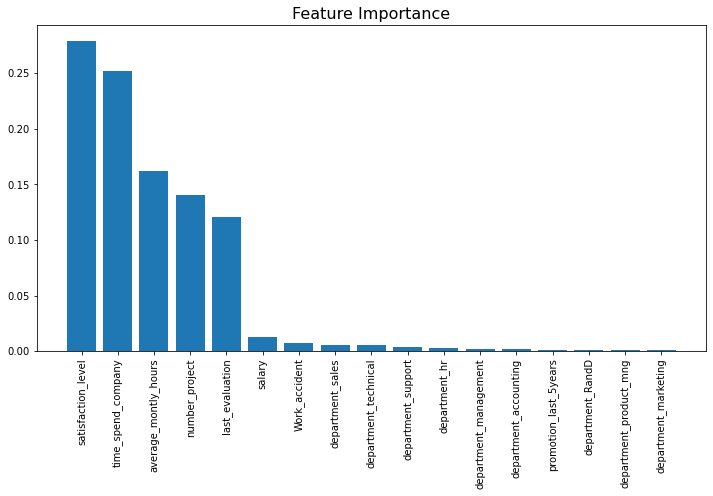

In [24]:
# Refit RF classifier
clf_rf = RandomForestClassifier(n_estimators=50,
                                criterion="entropy",
                                max_features=0.4,
                                min_samples_leaf=1,
                                class_weight="balanced",
                                n_jobs=-1,
                                random_state=123)


clf_rf.fit(StandardScaler().fit_transform(X_train), y_train)

# Plot features importance
importances = clf_rf.feature_importances_
indices = np.argsort(clf_rf.feature_importances_)[::-1]
plt.figure(figsize=(12, 6))
plt.bar(range(1, 18), importances[indices], align="center")
plt.xticks(range(1, 18), df.columns[df.columns != "left"][indices], rotation=90)
plt.title("Feature Importance", {"fontsize": 16});

# Descision Tree 

In [27]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
max_features=None, max_leaf_nodes=None,
min_impurity_split=1e-07, min_samples_leaf=1,
min_samples_split=2, min_weight_fraction_leaf=0.0,
presort=False, random_state=None, splitter='best')
y_pred = dt.predict(X_test)

In [28]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.9774642140320696

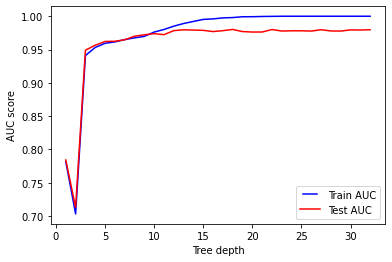

In [29]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

the tree perfectly predicts all of the train data,

In [30]:
dt.fit(X_train, y_train)
print ("\n\n ---Descision Tree Model---")
dt_roc_auc = roc_auc_score(y_test, dt.predict(X_test))
print ("Decision Tree classifier AUC = %2.2f" % dt_roc_auc)
print(classification_report(y_test, dt.predict(X_test)))



 ---Descision Tree Model---
Decision Tree classifier AUC = 0.98
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2286
           1       0.95      0.97      0.96       714

    accuracy                           0.98      3000
   macro avg       0.97      0.98      0.97      3000
weighted avg       0.98      0.98      0.98      3000

